# COMP9033 - Data Analytics Lab 07b: $k$ nearest neighbours regression
## Introduction

This lab focuses on anomaly detection using $k$ nearest neighbours regression. It's a direct counterpart to the linear regression from Lab 06. At the end of the lab, you should be able to use `scikit-learn` to:

- Create a $k$ nearest neighbours regression model.
- Use the model to predict new values.
- Measure the accuracy of the model.

### Getting started

Let's start by importing the packages we need. As in lab 07a, we're going to use the `neighbors` subpackage from `scikit-learn` to build k nearest neighbours models. We'll also use the `dummy` package to build a baseline model from we which can gauge how good our final model is.

In [2]:
%matplotlib inline
import pandas as pd

from math import sqrt # We'll need this later

from sklearn.cross_validation import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.pipeline import make_pipeline

Next, let's load the data. Write the path to your `server_load_historical.csv` file in the cell below:

In [3]:
path = "data/server_load_historical.csv"

The data we're loading is simulated network interface load data (in Gb/s) from a front end web server:

In [4]:
df = pd.read_csv(path, parse_dates=True, index_col="time")
df.head()

,server_load
time,
2017-03-01 00:00:00,17.195266
2017-03-01 00:05:00,22.716169
2017-03-01 00:10:00,9.441414
2017-03-01 00:15:00,32.120720
2017-03-01 00:20:00,20.047028


The data is noisy due to fluctuating user logins and data transfers and follows a seasonal trend:

       server_load
count   288.000000
mean     20.731350
std       8.058717
min      -1.233527
25%      15.375479
50%      20.501729
75%      26.670758
max      39.551862


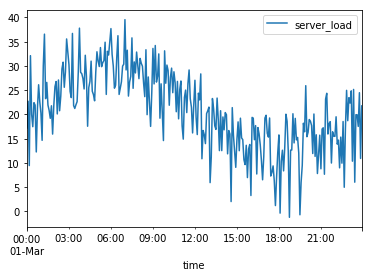

In [5]:
print(df.describe()) # Print summary statistics
df.plot(); # Plot the data

## Data modelling

Let's build a $k$ nearest neighbours regression model of the server load data. `scikit-learn` supports nearest neighbours functionality via the [`neighbors`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) subpackage. This subpackage supports $k$ nearest neighbors regression and classification as well as an unsupervised learning version of the algorithm. We can use the [`KNeighborsRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) class to build our model.

As before, we want to use our existing knowledge of server load to predict how it will behave in the future. Specifically, we're interested in modelling the behaviour of the server load over time. Therefore, our predictor variable will be the time of day and our target variable will be the server load.

Again, to get the time of day, we can subtract the first timestamp in our index from each timestamp in our index and convert the results to integer values:

In [6]:
time = (df.index - df.index[0]).astype('int') # Computes the time from midnight in nanoseconds

Next, we construct our feature matrix, $\mathbf{X}$, using our predictor values:

In [7]:
X = pd.DataFrame({'time': time}, index=df.index)
X.head()

,time
time,
2017-03-01 00:00:00,0
2017-03-01 00:05:00,300000000000
2017-03-01 00:10:00,600000000000
2017-03-01 00:15:00,900000000000
2017-03-01 00:20:00,1200000000000


And we set our target variable, $\mathbf{y}$, to be the server load data:

In [8]:
y = df['server_load']
y.head()

time
2017-03-01 00:00:00    17.195266
2017-03-01 00:05:00    22.716169
2017-03-01 00:10:00     9.441414
2017-03-01 00:15:00    32.120720
2017-03-01 00:20:00    20.047028
Name: server_load, dtype: float64

Let's use hold out validation to estimate our model error. We can use the [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method (just like last week's lab) to split the data into a training set and a test set. Let's use 20% of the data for testing:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Dummy modelling

Before we build the $k$ nearest neighbours model, let's build a dummy model, i.e. a naive model that predicts new values using a simple strategy. Dummy models are usually not good predictors (we usually won't use them to solve real problems), but are useful because they provide a baseline accuracy measurement for the data set, from which we can gauge the accuracy of any further models we build. In Lab 05, we built a rule-based model for SMS message spam detection for this purpose.

`scikit-learn` provides dummy model functionality via the [`dummy`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.dummy) subpackage. This subpackage provides both dummy regression and classification algorithms, which can be customised with different strategies. We can use the [`DummyRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html#sklearn.dummy.DummyRegressor) class to build a dummy regression model. `DummyRegressor` supports four different strategies for predicting values:

1. `strategy='mean'`: Predict new values as the mean value of the training set.
2. `strategy='median'`: Predict new values as the median value of the training set.
3. `strategy='quantile'`: Predict new values as some percentile value of the training set (the percentile value must also be specified using the `quantile` keyword argument).
4. `strategy='constant'`: Predict new values as some constant value (the constant value must also be specified using the `constant` keyword argument).

Let's build a model that predicts new values as the average of the training set values. As usual, we create an instance of the model building class and then use the `fit` method to fit it to the training data:

In [10]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

Now, we can measure the accuracy of our model by computing the mean absolute error (MAE) and the root mean square error (RMSE) on the test set:

MAE: 6.83 Gb/s
RMSE: 8.28 Gb/s


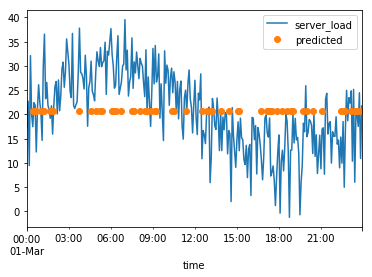

In [11]:
# Make predictions about the test data
y_pred = dummy.predict(X_test)

# Print error measurements
print('MAE: %.2f Gb/s' % mean_absolute_error(y_test, y_pred))
print('RMSE: %.2f Gb/s' % sqrt(mean_squared_error(y_test, y_pred))) # Use sqrt to get the RMSE from the MSE

# Plot the predictions
ax = df.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_test.index)
predicted.plot(ax=ax, marker='o', linewidth=0);

As can be seen, the dummy model is a poor fit for the data. But it does give us a baseline error level from which we can improve. Let's build a $k$ nearest neighbours model and see what the difference is.

### $k$ nearest neighbours modelling

Let's build our $k$ nearest neighbours model using a single stage pipeline and a grid search. Note how we don't need to do any scaling or polynomial feature generation like we did with the linear regression model in Lab 06.

In [12]:
pipeline = make_pipeline(
    KNeighborsRegressor()
)

parameters = {
    'kneighborsregressor__n_neighbors': [1, 2, 5, 10, 15, 20, 25, 30, 35, 40],
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__metric': ['manhattan', 'euclidean']
}

gs = GridSearchCV(pipeline, parameters, cv=5) # Use 5 fold cross validation when selecting the best model
gs.fit(X_train, y_train) # Fit using the training set

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kneighborsregressor__n_neighbors': [1, 2, 5, 10, 15, 20, 25, 30, 35, 40], 'kneighborsregressor__weights': ['uniform', 'distance'], 'kneighborsregressor__metric': ['manhattan', 'euclidean']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

We can check the parameters that led to the best model using the `best_params_` attribute of the grid search, after we have fitted our data:

In [13]:
gs.best_params_

{'kneighborsregressor__metric': 'manhattan',
 'kneighborsregressor__n_neighbors': 25,
 'kneighborsregressor__weights': 'uniform'}

Next, we can check how much of an improvement our best $k$ nearest neighbours model is over the dummy model by using it to predict values for the test set and measuring the error:

MAE: 4.56 Gb/s
RMSE: 5.64 Gb/s


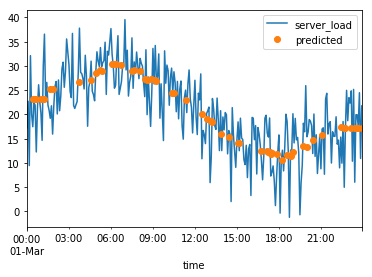

In [14]:
# Make predictions about the test data
y_pred = gs.predict(X_test)

# Print error measurementsa
print('MAE: %.2f Gb/s' % mean_absolute_error(y_test, y_pred))
print('RMSE: %.2f Gb/s' % sqrt(mean_squared_error(y_test, y_pred))) # Use sqrt to get the RMSE from the MSE

# Plot the predictions
ax = df.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_test.index)
predicted.plot(ax=ax, marker='o', linewidth=0);

As can be seen, the $k$ nearest neighbours model has learned the trend of the server load data and has signifcantly lower error than the dummy model. We can use this to construct an anomaly detector to automatically flag unusual server load activity in the future.

## Anomaly detection

Now that we have an accurate model, we can use it to detect anomalies in new data. Let's load some data where the server experiences an unusual load for the time of day:

In [15]:
path = 'data/server_load_new.csv'

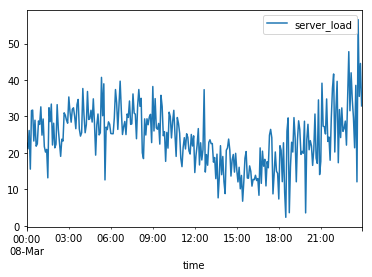

In [16]:
df2 = pd.read_csv(path, parse_dates=True, index_col='time')
df2.plot();

We can extract our predictor matrix and our target variable just like before:

In [17]:
X_new = pd.DataFrame({'time': (df2.index - df2.index[0]).astype('int')}, index=df2.index)
y_new = df2['server_load']

We can see the difference between the new data and the model by plotting like before:

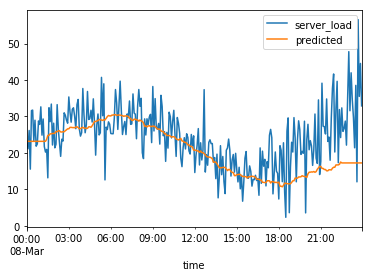

In [18]:
# Make predictions about the test data
y_pred = gs.predict(X_new)

# Plot the predictions
ax = df2.plot()

predicted = pd.DataFrame({'predicted': y_pred}, index=X_new.index)
predicted.plot(ax=ax);

While it is easy to gauge the anomaly visually, ideally an automatic system would detect it for us. This way, we don't have to micro-manage systems; instead, we can just sit back and wait to be alerted. Let's use a standard score test to find observations that are extremely different from what we expect.

The standard score test works by finding observations ($x_i$) in a sample ($X = \{x_1, x_2, \ldots, x_n\}$) that are more than a given number ($\lambda$) of standard deviations ($\sigma_x$) away from the average value ($\bar{x}$), i.e.

\begin{align}
    \left| z(x_i) \right| > \lambda,
\end{align}
where
\begin{align}
    z(x_i) = \frac{x_i - \bar{x}}{\sigma_x}.
\end{align}

We can combine the equations above to work out the range of non-outlying observations, i.e.

\begin{align}
    x_i \in [\bar{x} - \lambda \sigma_x, \bar{x} + \lambda \sigma_x].
\end{align}

Consequently, any observation that lies outside this range can be considered an anomaly.

In our case, we want to detect observations that deviate significantly from the predicted value given by our model. We can do this by checking for model prediction errors that lie outside the range of non-outlying prediction errors. Let's use $\lambda = 3$ to find instances where the model prediction error is more than three standard deviations from the mean prediction error:

In [19]:
# The prediction error on the training set represents the "normal" error we should expect
error = y_train - gs.predict(X_train)

# Compute the range of non-outlying prediction errors
l = 3 # l = lambda
min_error = error.mean() - l * error.std()
max_error = error.mean() + l * error.std()

Next, we compute the prediction error on the new data:

In [20]:
error = y_new - gs.predict(X_new)

Plotting the output, we can see exactly where an automated system would have shown us that an anomaly was occurring:

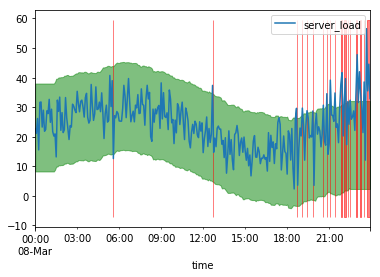

In [21]:
ax = df2.plot()
ax.fill_between(df2.index, y_pred + min_error, y_pred + max_error, color='green', alpha=0.5)
ax.fill_between(df2.index, ax.get_ylim()[0], ax.get_ylim()[1], color='red', alpha=0.5,
                where=(error < min_error) | (error > max_error));

As can be seen, the system detects the server load anomaly that occurs after 18:00, but it also catches two other anomalies, one just before 06:00 and the other just after 12:00. In these cases, the anomaly detector has misclassified the data as anomalous (i.e. it has made a mistake). We can increase our value of $\lambda$ to ensure that this doesn't happen, at the cost of detecting fewer genuine anomalies. Alternatively, we can accept that the error rate is small enough to be tolerable, and perhaps suppress alerts for transient anomalies with short lifespans.